In [18]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

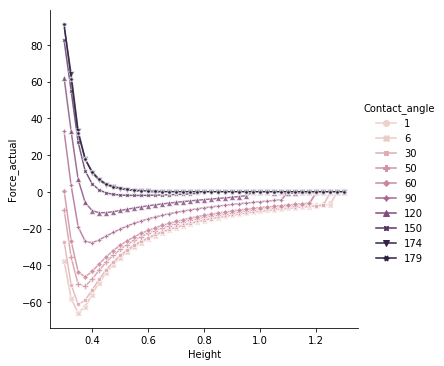

In [68]:
simu_folderpath = 'E:/Work/Surface Evolver/Data/Bubble_Bridge/20201006 model data final (af=2, l_d=10)/pin_radius_2 (fluid)/'

simu_df = pd.DataFrame()
with os.scandir(simu_folderpath) as folder:
    for file in folder:
        if file.is_file() and file.path.endswith( ('.txt') ) and file.name != 'rupture.txt':
            df_temp = pd.read_csv(file.path,delimiter='\t')
            #df_temp['ys/F'] = -1/(2*np.pi*df_temp['Force_Calc']) #inverse
            df_temp['File path'] = file.path
            simu_df = simu_df.append(df_temp)

simu_df['Simulation folder'] = simu_folderpath
simu_df['Force_actual'] = simu_df['Force_Calc']*2*np.pi
simu_df['Contact_angle'] = 180 - simu_df['Bottom_Angle']
simu_df.reset_index(inplace=True)
#simul_plot(simu_df)

sns.relplot(data=simu_df,
            x = "Height",
            y = "Force_actual",
            hue = "Contact_angle",
            style = "Contact_angle",
            kind = 'line',
            sort = False,
            markers = True,
            dashes = False,
            alpha = 0.8,
            legend = 'full',
            facet_kws={"legend_out": True})
plt.show()

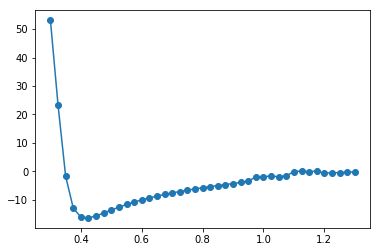

In [121]:
#compute force curve for arbitrary contact angle
def get_fd(simu_df, contact_angle):
    F_fit = []
    h_range = []
    for h in simu_df['Height'].unique():
        simu_df_h = simu_df[simu_df['Height'] == h]
        #5th order polynomial fit of Force-Contact angle data
        fah_fit = np.polyfit(simu_df_h['Contact_angle'], simu_df_h['Force_actual'], 5)
        F_fit.append(np.polyval(fah_fit,contact_angle))
        h_range.append(h)
    
    return F_fit, h_range

# F_fit, h_range = get_fd(simu_df, 110)
# plt.plot(h_range, F_fit, '-o')
# plt.show()

150.81587773135712 250.0


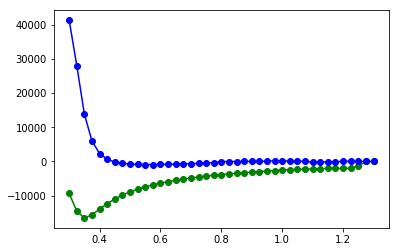

In [135]:
Dp_Dh = 50 #Dp/Dh
alpha = 0.1
asp_ratio = 10
s_f = 1
y_fa = 1 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 2 #fluid-water interfacial tension (N/m)
y_wa = 3 #water surface tension (N/m)
phi_f = 2


theta_fa = 6#6 #fluid-substrate contact angle in air
theta_wa = 24#20 #water-substrate contact angle in air

# theta_fa = 50#56 #fluid-substrate contact angle in air
# theta_wa = 120#90 #water-substrate contact angle in air
def get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa, 
                 theta_fa, theta_wa, phi_f, s_f):
    cos_fw = (y_fa*np.cos(theta_fa*np.pi/180)-y_wa*np.cos(theta_wa*np.pi/180))/y_fw
    cos_fw = -1 if cos_fw <-1 else cos_fw
    cos_fw = 1 if cos_fw >1 else cos_fw
    theta_fw = np.arccos(cos_fw)*180/np.pi 


    N = alpha*(Dp_Dh**2)
    print(theta_fw, N)
    F_a, h = get_fd(simu_df, theta_fa)
    F_w, h = get_fd(simu_df, theta_fw)
    F_phil_a = [f*y_fa*s_f*N for f in F_a]
    F_phil_w = [f*y_fw*s_f*N for f in F_w]
    return F_phil_a, F_phil_w, h

F_phil_a, F_phil_w, h = get_fd_array(Dp_Dh, alpha, asp_ratio, y_fa, y_fw, y_wa, 
                                     theta_fa, theta_wa, phi_f, s_f)
plt.plot(h, F_phil_a, '-og')
plt.plot(h, F_phil_w, '-ob')
plt.show()

In [132]:
min(F_phil_a)

-16562.47944436159

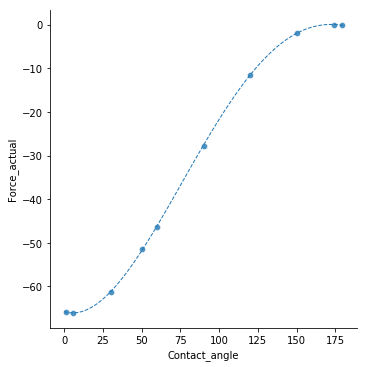

In [69]:
group_vars = ['Contact_angle', 'Pin_Radius', 'Elastic_Modulus', 'Aspect_Ratio',
              'Ambient_Pressure']
simu_adh_df = simu_df.loc[simu_df.groupby(group_vars)["Force_actual"].idxmin()]

#5th order polynomial fit of Force-Contact angle data
fr_fit = np.polyfit(simu_adh_df['Contact_angle'], simu_adh_df['Force_actual'], 5)
contact_angle_range = np.linspace(0,180,100)
force_fit = np.polyval(fr_fit,contact_angle_range)


sns.relplot(data=simu_adh_df,
            x = "Contact_angle",
            y = "Force_actual",
            kind = 'scatter',
            markers = True,
            dashes = False,
            alpha = 0.8)

plt.plot(contact_angle_range, force_fit, '--', linewidth = 1)

plt.show()

In [109]:
N_h = 500 #number of hairs
D_h = 4e-6 #hair diameter (m)
D_p = 200e-6 #pad diameter (m)
L_h = 40e-6 #hair length (m)
y_fa = 27e-3 #fluid-air interfacial tension (N/m) https://pubs.acs.org/doi/10.1021/la960800g
y_fw = 55e-3 #fluid-water interfacial tension (N/m)
y_wa = 72e-3 #water surface tension (N/m)
V_f = 4.2e-18 #fluid volume (m^3)
V_b = 1.2e-12 #bubble volume (m^3)


s_f = (3*V_f/(4*np.pi))**(1/3) #s_f
s_b = (3*V_b/(4*np.pi))**(1/3) #s_b
phi_f = D_h/(2*s_f) #D_h/2s_f
phi_b = D_p/(2*s_b) #D_p/2s_b

theta_fa = 6 #fluid-substrate contact angle in air
theta_wa = 20 #water-substrate contact angle in air

theta_fa = 56 #fluid-substrate contact angle in air
theta_wa = 90 #water-substrate contact angle in air

cos_fw = (y_fa*np.cos(theta_fa*np.pi/180)-y_wa*np.cos(theta_wa*np.pi/180))/y_fw
cos_fw = -1 if cos_fw <-1 else cos_fw
cos_fw = 1 if cos_fw >1 else cos_fw
theta_fw = np.arccos(cos_fw)*180/np.pi 
print(theta_fw)

F_phil_a = np.polyval(fr_fit,theta_fa)*y_fa*s_f*N_h
F_phil_w = np.polyval(fr_fit,theta_fw)*y_fw*s_f*N_h
print(F_phil_a/1e-6, F_phil_w/1e-6)

74.06701290401661
-655.0116969377767 -1031.0316931168327


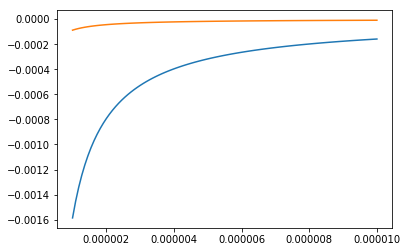

In [95]:
D_h_array = np.linspace(1e-6,10e-6,100)
phi_f = 2
alpha = 0.1

F_air = []
F_water = []
N_array = []
for D in D_h_array:
    N = alpha*(D_p**2)/(D**2)
    N_array.append(N)
    s_f = D/(phi_f*2)
    F_air.append(np.polyval(fr_fit,theta_fa)*y_fa*s_f*N)
    F_water.append(np.polyval(fr_fit,theta_fw)*y_fw*s_f*N)

plt.plot(D_h_array, F_air)
plt.plot(D_h_array, F_water)
plt.show()